# Import packages

In [41]:
import pickle
import pandas as pd
import numpy as np
import os
import shap
import spacy
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch
import transformers
import shap
from transformers import AutoTokenizer, DistilBertForSequenceClassification
import joblib

In [43]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


# Test

In [ ]:
# DONE 1: Load the model and scaler
# Load data
db_data_path = '../datasets/distilbert_data/train/'
db_files = [file for file in os.listdir(db_data_path) if file.endswith('clean.csv')]
db_files.sort()
file = db_files[1]
data = pd.read_csv(db_data_path + file)

# Load the corresponding distilbert model and tokenizer from huggingface
metric_name = file.split('.')[0].split('_')[0] # Get the metric name to load the corresponding model
print(metric_name)
hub_path = 'lenguyen/' + 'distilbert_' + metric_name
model = DistilBertForSequenceClassification.from_pretrained(hub_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(hub_path)

# Load scaler to inverse transform the predicted values
scaler = joblib.load(open('../models/distilbert_data/' + metric_name + '_scaler.pkl', 'rb'))

In [ ]:
# Initialise explainer
explainer = shap.Explainer(f_batch, tokenizer)

# Get the first 10 samples from the dataset
texts = data['text'].values

# Explain the model's predictions using SHAP values
shap_values = explainer(texts, fixed_context=1, nsamples=300)

shap.plots.bar(shap_values.abs.mean(0))

# Load data, model and scaler

In [128]:
# Get list of flies from DistilBERT's data folder
db_data_path = '../datasets/distilbert_data/train/'
db_files = [file for file in os.listdir(db_data_path) if file.endswith('clean.csv')]
db_files.sort()
db_files

['EBIT_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv']

In [134]:
# Get list of flies from FinBERT's data folder
fb_data_path = '../datasets/finbert_data/train/'
fb_files = [file for file in os.listdir(fb_data_path) if file.endswith('clean.csv')]
fb_files.sort()
fb_files

['EBIT_train__text_clean.csv',
 'EarningsPerShareDiluted_train__text_clean.csv',
 'NetCashProvidedByUsedInFinancingActivities_train__text_clean.csv',
 'NetCashProvidedByUsedInInvestingActivities_train__text_clean.csv',
 'NetIncomeLoss_train__text_clean.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_train__text_clean.csv']

## Function to load data, model and scaler

In [133]:
# Function to load the model and scaler 
def load_data_model_and_scaler(file_path, file_name, hub_path, scaler_path):
    # Load data 
    data = pd.read_csv(file_path + file_name)
    
    # Load model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained(hub_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(hub_path)
    
    # Load scaler to inverse transform the predicted values
    scaler = joblib.load(open(scaler_path, 'rb'))
    return data, model, tokenizer, scaler    

# Interpret models

In [100]:
# Predict function for SHAP
def predict(text):
    input = torch.tensor(
        tokenizer.encode(text,padding='max_length', truncation=True, max_length=300)
    ).to(device)
    input = input.unsqueeze(0)
    
    with torch.no_grad():
        output = model(input)
        logit = output[0]
        logit = logit.cpu().numpy()
        prediction = scaler.inverse_transform(logit).item()
    return prediction

def f_batch(texts):
    predictions = []
    for text in texts:
        prediction = predict(text)
        predictions.append(prediction)
    return predictions

In [168]:
# Function to explain the model with SHAP
def shap_interpret_model(data, model, tokenizer, scaler, n_samples=None):
    # Get a sample of the data when data is too large
    if n_samples is not None:
        if len(data) > n_samples:
            sample = data.sample(n_samples)
            sample = sample.reset_index(drop=True)
        else:
            sample = data    
    
    # Get the explainer
    explainer = shap.Explainer(f_batch, tokenizer)
    
    # Get the shap values
    shap_values = explainer(sample['text'], fixed_context=1)
    
    # Plot the shap values
    shap.plots.bar(shap_values.abs.mean(0))
    
    return shap_values

# Run through all data and their corresponding models

## DistilBERT

In [153]:
import requests

--------------INTERPRETING FINBERT REGRESSION MODEL OF EBIT--------------


PartitionExplainer explainer:  21%|██        | 38/183 [00:32<02:14,  1.08it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 40/183 [00:44<07:05,  2.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 130/183 [02:34<00:52,  1.01it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████▏ | 149/183 [03:12<00:47,  1.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 163/183 [03:35<00:22,  1.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 184it [04:03,  1.43s/it]                         


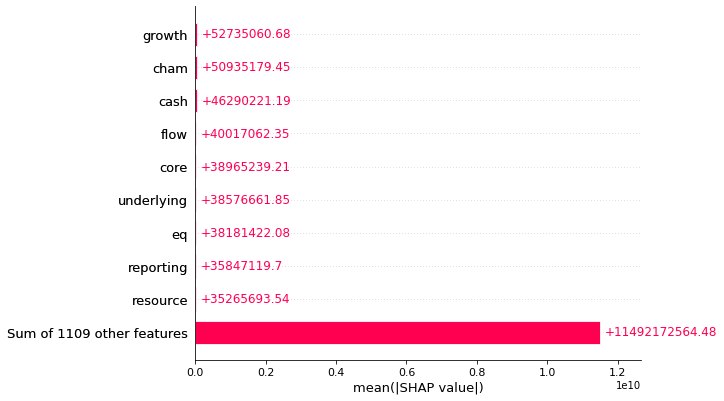

--------------INTERPRETING FINBERT REGRESSION MODEL OF EarningsPerShareDiluted--------------


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 11/354 [00:14<04:48,  1.19it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▍         | 17/354 [00:24<07:01,  1.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 18/354 [00:34<20:45,  3.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 45/354 [01:08<02:46,  1.86it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 49/354 [01:15<05:30,  1.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 76/354 [01:49<03:18,  1.40it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 105/354 [02:33<04:11,  1.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  31%|███       | 110/354 [02:52<09:20,  2.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 123/354 [03:20<04:40,  1.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▊      | 137/354 [03:40<02:40,  1.35it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 140/354 [03:54<09:42,  2.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 158/354 [04:24<03:01,  1.08it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 171/354 [04:45<03:36,  1.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 181/354 [05:02<03:14,  1.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 192/354 [05:27<08:02,  2.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 194/354 [05:37<09:22,  3.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 197/354 [05:45<06:46,  2.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 200/354 [05:58<08:11,  3.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 212/354 [06:17<02:52,  1.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 248/354 [07:08<02:15,  1.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 250/354 [07:17<04:33,  2.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▋  | 270/354 [07:49<01:33,  1.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████▉  | 283/354 [08:07<01:23,  1.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 293/354 [08:26<01:19,  1.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 307/354 [08:49<01:01,  1.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 315/354 [09:08<01:03,  1.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 320/354 [09:18<00:50,  1.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 324/354 [09:29<00:53,  1.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 325/354 [09:35<01:28,  3.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 338/354 [10:02<00:28,  1.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 339/354 [10:09<00:51,  3.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 345/354 [10:20<00:15,  1.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 347/354 [10:30<00:20,  2.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▉| 350/354 [10:42<00:11,  2.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 355it [10:52,  1.87s/it]                         


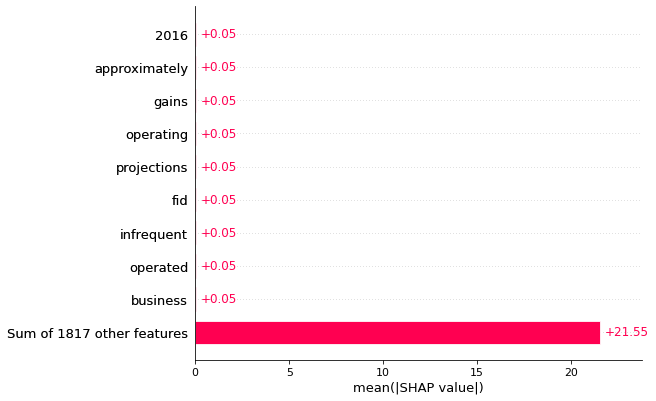

--------------INTERPRETING FINBERT REGRESSION MODEL OF NetCashProvidedByUsedInFinancingActivities--------------
ERROR: NetCashProvidedByUsedInFinancingActivities model is not available in hub
--------------INTERPRETING FINBERT REGRESSION MODEL OF NetCashProvidedByUsedInInvestingActivities--------------


PartitionExplainer explainer: 32it [00:39,  1.66s/it]                        


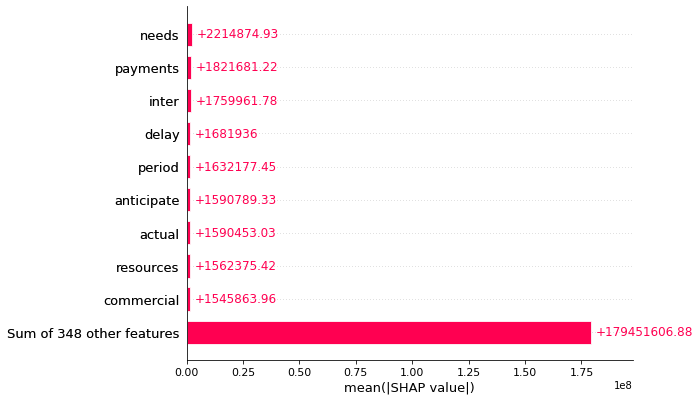

--------------INTERPRETING FINBERT REGRESSION MODEL OF NetIncomeLoss--------------


PartitionExplainer explainer:   9%|▉         | 90/1000 [01:17<10:42,  1.42it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 131/1000 [02:04<21:18,  1.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 182/1000 [03:06<11:52,  1.15it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▊        | 186/1000 [03:21<30:29,  2.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  19%|█▉        | 188/1000 [03:30<44:43,  3.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 207/1000 [04:06<24:54,  1.88s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██▏       | 213/1000 [04:19<19:25,  1.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 220/1000 [04:32<18:05,  1.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 235/1000 [04:56<10:54,  1.17it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 281/1000 [06:00<16:49,  1.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 285/1000 [06:15<26:06,  2.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 299/1000 [06:35<11:50,  1.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 305/1000 [06:52<17:00,  1.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 392/1000 [08:40<11:08,  1.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 401/1000 [09:01<11:21,  1.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▍     | 448/1000 [09:57<11:46,  1.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  46%|████▋     | 464/1000 [10:19<11:40,  1.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 469/1000 [10:31<12:36,  1.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 574/1000 [12:33<06:58,  1.02it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 630/1000 [13:34<05:06,  1.21it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▎   | 637/1000 [13:50<07:02,  1.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 655/1000 [14:19<09:34,  1.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▍  | 749/1000 [16:13<04:09,  1.01it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 755/1000 [16:28<05:26,  1.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 759/1000 [16:40<07:31,  1.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 804/1000 [17:35<02:54,  1.13it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 818/1000 [17:56<02:28,  1.23it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 819/1000 [18:06<10:44,  3.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 857/1000 [18:50<01:38,  1.45it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▎| 925/1000 [20:05<01:24,  1.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 930/1000 [20:14<01:21,  1.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 952/1000 [20:38<00:38,  1.26it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 1001it [21:41,  1.32s/it]                          


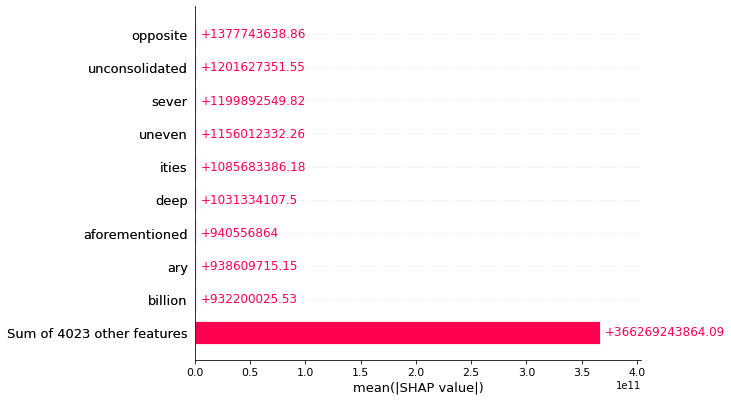

--------------INTERPRETING FINBERT REGRESSION MODEL OF RevenueFromContractWithCustomerExcludingAssessedTax--------------


PartitionExplainer explainer:   4%|▎         | 36/1000 [00:45<17:51,  1.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█▏        | 113/1000 [02:10<11:55,  1.24it/s] 

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 123/1000 [02:23<12:38,  1.16it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 139/1000 [02:49<12:51,  1.12it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▍       | 247/1000 [05:03<12:48,  1.02s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 315/1000 [06:29<15:24,  1.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 353/1000 [07:10<08:08,  1.32it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 363/1000 [07:25<09:40,  1.10it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 408/1000 [08:13<11:05,  1.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 439/1000 [08:49<08:03,  1.16it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 594/1000 [11:24<05:42,  1.19it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 638/1000 [12:26<11:11,  1.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 658/1000 [12:51<05:46,  1.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 676/1000 [13:15<06:01,  1.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 695/1000 [13:49<07:59,  1.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 700/1000 [14:03<09:13,  1.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 760/1000 [15:18<04:16,  1.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  79%|███████▉  | 791/1000 [15:59<02:54,  1.20it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 806/1000 [16:30<05:07,  1.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 815/1000 [16:45<03:21,  1.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 824/1000 [17:02<02:49,  1.04it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 829/1000 [17:11<03:29,  1.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▎ | 835/1000 [17:26<05:01,  1.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▍| 947/1000 [19:26<00:53,  1.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 969/1000 [20:03<00:33,  1.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 973/1000 [20:12<00:44,  1.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  99%|█████████▊| 987/1000 [20:36<00:13,  1.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 1001it [20:59,  1.27s/it]                          


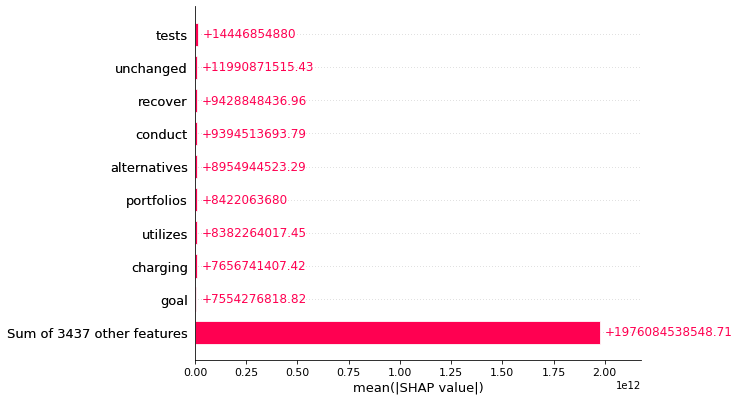

In [169]:
for i in range(len(db_files)):
    file = db_files[i]
    metric_name = file.split('.')[0].split('_')[0]
    
    print(f"--------------INTERPRETING FINBERT REGRESSION MODEL OF {metric_name}--------------")
    
    # Specify the paths to load the data, model and scaler 
    try:
        hub_path = 'lenguyen/' + 'distilbert_' + metric_name
        scaler_path = '../models/distilbert_data/' + metric_name + '_scaler.pkl'
        
        # Load data, model and scaler
        data, model, tokenizer, scaler = load_data_model_and_scaler(db_data_path, file, hub_path, scaler_path)
        
        # Explain the model
        shap_values = shap_interpret_model(data, model, tokenizer, scaler, n_samples=1000)
        
        # Save shap values
        joblib.dump(scaler, f'../models/distilbert_data/{metric_name}_shap-values.pkl')
    except (Exception) as e:
        print(f"ERROR: {metric_name} model is not available in hub")
        continue

## FinBERT

--------------INTERPRETING FINBERT REGRESSION MODEL OF EBIT--------------


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 32/187 [00:20<01:16,  2.01it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 188it [02:01,  1.48it/s]                         


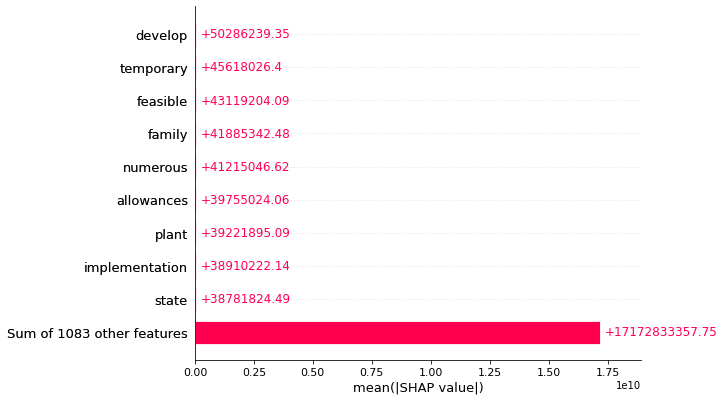

--------------INTERPRETING FINBERT REGRESSION MODEL OF EarningsPerShareDiluted--------------


PartitionExplainer explainer:  12%|█▏        | 42/354 [00:41<02:48,  1.85it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▊      | 137/354 [02:08<02:09,  1.67it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  49%|████▉     | 173/354 [02:44<02:58,  1.02it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 355it [05:29,  1.04it/s]                         


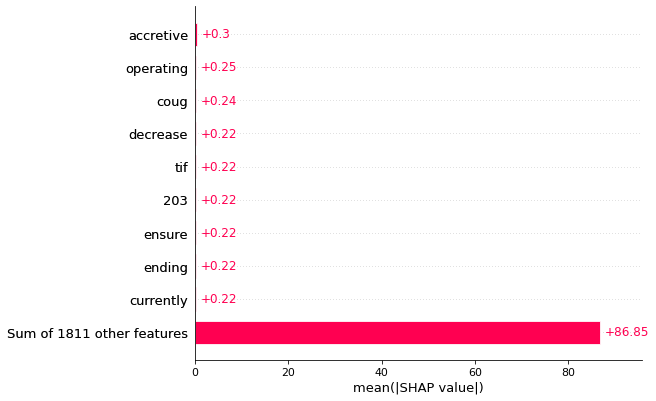

--------------INTERPRETING FINBERT REGRESSION MODEL OF NetCashProvidedByUsedInFinancingActivities--------------


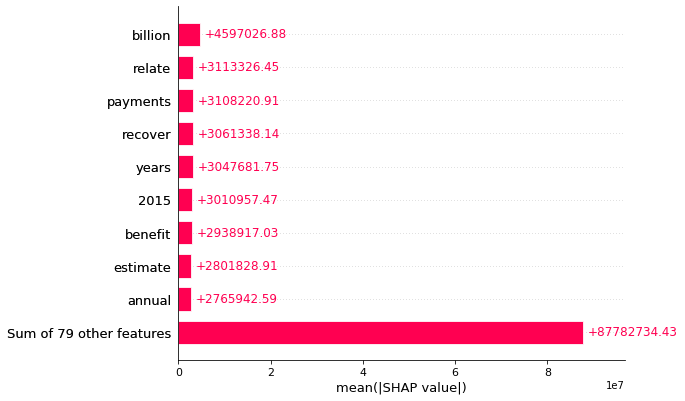

--------------INTERPRETING FINBERT REGRESSION MODEL OF NetCashProvidedByUsedInInvestingActivities--------------


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

PartitionExplainer explainer: 31it [00:27,  1.24s/it]                        


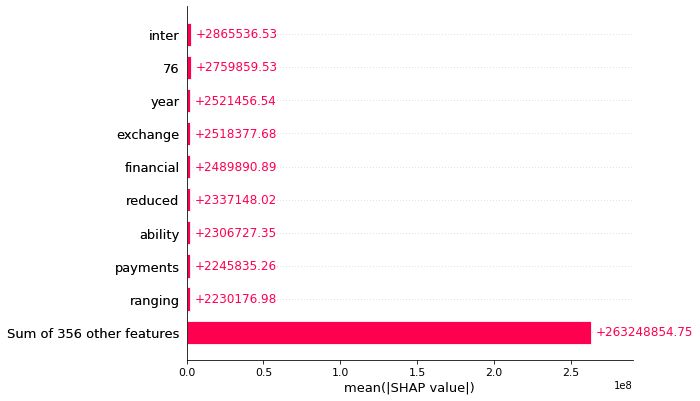

--------------INTERPRETING FINBERT REGRESSION MODEL OF NetIncomeLoss--------------


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|▏         | 13/1000 [00:20<07:25,  2.22it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 24/1000 [00:35<12:36,  1.29it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 317/1000 [03:36<05:30,  2.06it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▍      | 348/1000 [03:59<11:24,  1.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  51%|█████     | 509/1000 [05:46<03:02,  2.69it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 627/1000 [07:22<02:55,  2.13it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 1001it [10:55,  1.52it/s]                          


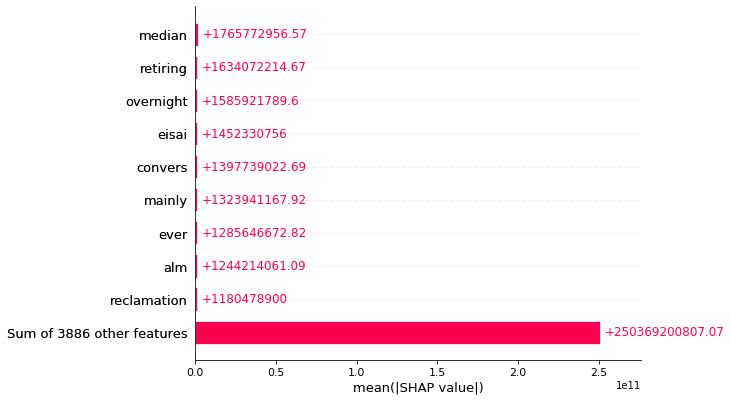

--------------INTERPRETING FINBERT REGRESSION MODEL OF RevenueFromContractWithCustomerExcludingAssessedTax--------------


config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

PartitionExplainer explainer:   2%|▏         | 19/1000 [00:13<13:49,  1.18it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 54/1000 [00:43<17:31,  1.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 57/1000 [00:50<23:51,  1.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▎        | 125/1000 [01:53<12:24,  1.17it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 297/1000 [03:51<06:27,  1.82it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  39%|███▉      | 389/1000 [04:57<08:08,  1.25it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  41%|████      | 406/1000 [05:13<05:31,  1.79it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 450/1000 [05:49<12:53,  1.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 517/1000 [06:29<05:41,  1.41it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 529/1000 [06:42<05:47,  1.35it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  54%|█████▍    | 539/1000 [06:53<04:57,  1.55it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▋    | 564/1000 [07:20<05:36,  1.30it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 708/1000 [08:57<03:14,  1.50it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 806/1000 [10:01<02:07,  1.52it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 808/1000 [10:07<05:11,  1.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▊ | 886/1000 [11:02<01:45,  1.08it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  89%|████████▉ | 892/1000 [11:12<01:41,  1.07it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 910/1000 [11:28<00:59,  1.52it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 955/1000 [12:04<00:22,  2.02it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 1001it [12:41,  1.30it/s]                          


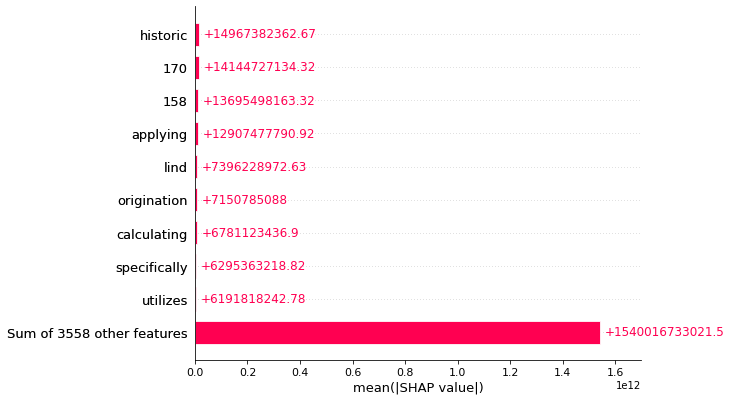

In [183]:
for i in range(len(fb_files)):
    file = fb_files[i]
    metric_name = file.split('.')[0].split('_')[0]
    
    print(f"--------------INTERPRETING FINBERT REGRESSION MODEL OF {metric_name}--------------")
    
    # Specify the paths to load the data, model and scaler 
    try: 
        hub_path = 'lenguyen/' + 'finbert_' + metric_name
        scaler_path = '../models/finbert_data/' + metric_name + '_scaler.pkl'
        
        # Load data, model and scaler
        data, model, tokenizer, scaler = load_data_model_and_scaler(fb_data_path, file, hub_path, scaler_path)
        
        # Explain the model
        shap_values = shap_interpret_model(data, model, tokenizer, scaler, n_samples=1000)
        
        # Save shap values
        joblib.dump(scaler, f'../models/finbert_data/{metric_name}_shap-values.pkl')
        
    except (Exception) as e:
        if e == 'HTTPError':
            print(f"ERROR: {metric_name} model is not available in hub")
            continue
        else:
            print(e)
            break
